# Basic Theory Testing

We genereate some load up some data that differ by one datapoint, and either do or do not satisfy the requirements. We then optimise and show one but not the other is modularly represented.

In [2]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import vmap, value_and_grad, grad, jit, random
import jax.nn as jnn
import math
import optax
import scipy
from mpl_toolkits.mplot3d import Axes3D
import os
import datetime
from metrics import compute_linear_metrics

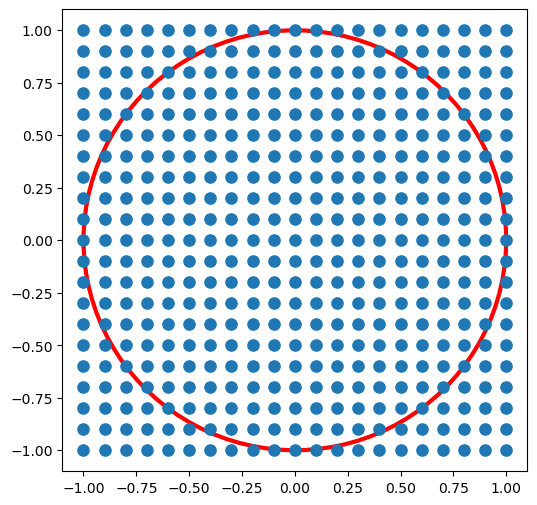

In [3]:
def draw_ellipse(points, num_thetas = 100):
    point_demeaned = points - np.mean(points, axis = 1)[:,None]
    covar = np.mean(point_demeaned[0,:]*point_demeaned[1,:])
    b_x = -np.min(point_demeaned[0,:])
    b_y = -np.min(point_demeaned[1,:])

    plt.figure(figsize = (6, 6))

    A = np.array([[b_x**2, -covar], [-covar, b_y**2]])
    thetas = np.linspace(0, 2*np.pi, num_thetas)
    unit_vecs = np.vstack([np.cos(thetas), np.sin(thetas)])
    ellipse_points = unit_vecs/np.sqrt(np.diag(unit_vecs.T@np.linalg.inv(A)@unit_vecs)[None,:])
    plt.plot(ellipse_points[0,:], ellipse_points[1,:], 'r', lw = 3)
    plt.scatter(point_demeaned[0,:], point_demeaned[1,:], s = 65, zorder = 2)

step = 0.1
grad = 1 # What line do you want to remove along

# Create raw points
x, y = np.meshgrid(np.arange(-1, 1+0.0001, step), np.arange(-1, 1+0.0001, step))
points = np.stack([np.ndarray.flatten(x), np.ndarray.flatten(y)])
points_raw = np.copy(points)
points_demeaned = points - np.mean(points, axis = 1)[:,None]

draw_ellipse(points_demeaned)

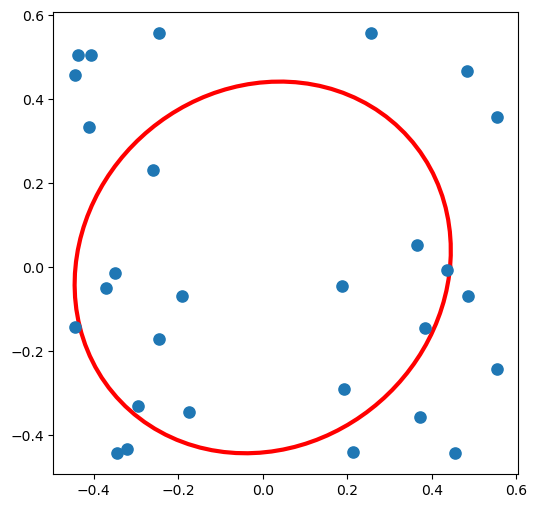

In [4]:
load_path = f"Fig1_Points.npy"
points = np.load(load_path)
points_demeaned = points - np.mean(points, axis = 1)[:,None]
draw_ellipse(points_demeaned)

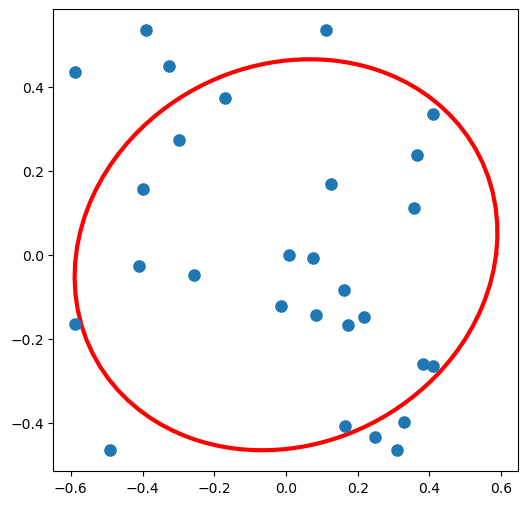

In [5]:
point_hard_code = np.array([[0, 0, 0.9, 0.1, 1,1, 0.7, 0.2],[0.9, 0.3, 0, 0, 0.8, 0.2, 1, 1]])
points = np.hstack([np.random.uniform(0, 1, [2,20]), point_hard_code])
points_demeaned = points - np.mean(points, axis = 1)[:,None]

#keep = np.linalg.norm(point_demeaned, axis = 0) < 1.03
#points = point_demeaned[:,keep]
draw_ellipse(points_demeaned)

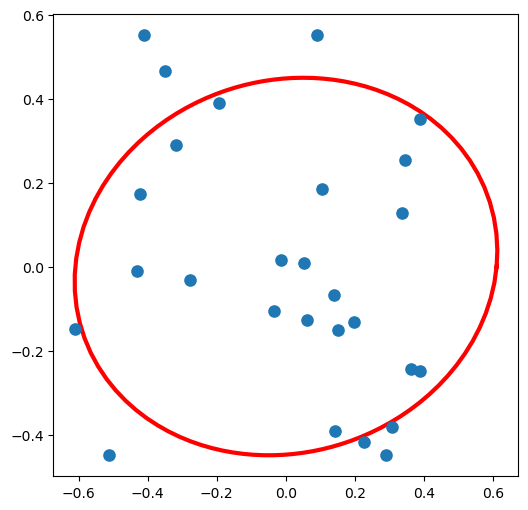

In [6]:
points = np.delete(points, 20, 1)
points_demeaned = points - np.mean(points, axis = 1)[:,None]

#keep = np.linalg.norm(point_demeaned, axis = 0) < 1.03
#points = point_demeaned[:,keep]
draw_ellipse(points_demeaned)

In [7]:
# Setup some saving things
date = datetime.datetime.now()
today = date.strftime('%Y%m%d')
now = date.strftime('%H:%M:%S')
random_seed = np.random.choice(1000000)

# Make sure folder is there
if not os.path.isdir(f"./data/"):
    os.mkdir(f"./data/")
if not os.path.isdir(f"data/{today}/"):
    os.mkdir(f"data/{today}/")
# Now make a folder in there for this run
savepath = f"data/{today}/{now}_{random_seed}/"
if not os.path.isdir(f"data/{today}/{now}_{random_seed}"):
    os.mkdir(f"data/{today}/{now}_{random_seed}")

In [8]:
np.save(f"data/{today}/{now}_{random_seed}/points.npy", points_demeaned)

In [9]:
random_seed = 10

In [11]:
H = 10

I = np.random.normal(0,1, [H,3])
points_demeaned = points - np.mean(points, axis = 1)[:,None]
points_bias = np.vstack([points_demeaned, np.ones([1,points_demeaned.shape[1]])])

@jit
def generate_rep(I, inputs):
    g = jnn.relu(I@inputs)
    #g = I@inputs
    g_bias = jnp.vstack([g, jnp.ones(g.shape[1])[None,:]])
    return g_bias

@jit
def loss_weight_I(I):
    return jnp.sum(jnp.power(I[:,:-1],2))

@jit
def generate_R(g, outputs):
    mat0 = jnp.matmul(g, g.T)
    mat1 = jnp.matmul(g, outputs.T)
    mat2 = jnp.matmul(jnp.linalg.inv(mat0 + 0.01*jnp.eye(H+1)), mat1)
    return mat2

@jit
def loss_fit(g, R, outputs):
    preds = R.T@g
    return jnp.linalg.norm(outputs - preds) 

@jit
def loss_R(R):
    R_sub = R[:-1,:]
    return jnp.sum(jnp.power(R_sub, 2))

@jit
def loss_act(g):
    return jnp.sum(jnp.power(g[:-1,:], 2))


@jit
def loss_pos(g):
    g_neg = (g - jnp.abs(g))/2
    L_pos = -jnp.sum(g_neg)
    return L_pos    

# Loss function parameters
mu_fit = 1000000
mu_G = 1
mu_R = 1
mu_I = 1
mu_pos = 10000
fit_thresh = 0.01


@jit
def loss(params, inputs, outputs):
    g = generate_rep(params["I"], inputs)
    R = generate_R(g, outputs)

    return mu_fit*jnn.relu(loss_fit(g, R, outputs)-fit_thresh) + mu_G*loss_act(g) + mu_I*loss_weight_I(params["I"]) + mu_R*loss_weight_I(R) + mu_pos*loss_pos(g)
    
@jit
def update(params, inputs, outputs, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, inputs, outputs)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, value

# Simulation parameters
learning_rate = 1e-5

re_init = 1
if re_init:
    key = random.PRNGKey(random_seed)
    I = random.normal(key, (H, 3))*0.001
    I = I.at[:,-1].set(2)
    optimizer = optax.adam(learning_rate)
    # Obtain the `opt_state` that contains statistics for the optimizer.
    params = {'I': I}
    opt_state = optimizer.init(params)
print(loss(params, points_bias, points_demeaned))
min_loss = np.infty

#config_dict = {'mu_fit':mu_fit, 'mu_G':mu_G, 'mu_R':mu_R, 'mu_I':mu_I, 'mu_pos':mu_pos, 'fit_thresh':fit_thresh, 'learning_rate':learning_rate, 'step':step,
              #   'v':v, 'Delta':Delta, 'H':H, 'act_reg':act_reg}
#np.save(f"data/{today}/{now}_{random_seed}/config_dict", config_dict)

I0000 00:00:1727259113.996963       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


2204740.5


In [12]:
# Optimisation, run and re-run until it stops hitting new records
T = 10000000
print_iter = 10000

for t in range(T):
    params, opt_state, loss = update(params, points_bias, points, opt_state)

    if t % print_iter == 0:
        g = generate_rep(params["I"], points_bias)
        R = generate_R(g, points)

        L_f = loss_fit(g, R, points)
        L_a = loss_act(g)
        L_R = loss_weight_I(R)
        L_I = loss_weight_I(params["I"])    
        L_p = loss_pos(g)
        print(f"Step {t}, Loss: {loss:.5f}, Fit: {L_f:.5f}, Act: {L_a:.5f}, R: {L_R:.5f}, I: {L_I:.5f}, pos: {L_p:.5f}")
        #print(f"Step {t}, Loss: {loss:.5f}")#, Fit: {L_f:.5f}, Act: {L_a:.5f}, Wei: {L_w:.5f}, R: {L_R:.5f}, Pos: {L_p:.5f}, PI: {L_PI:.5f}")

        min_this_step = 0

    if loss < min_loss:
        params_best = params
        min_loss = loss
        if min_this_step == 0:
            print(f'New min! {loss}')
            min_this_step = 1

Step 0, Loss: 2204675.50000, Fit: 2.21346, Act: 1080.00232, R: 1.01490, I: 0.00004, pos: -0.00000
New min! 2204675.5
Step 10000, Loss: 163581.67188, Fit: 0.17287, Act: 1079.93542, R: 17.03141, I: 0.10455, pos: -0.00000
New min! 163257.859375
Step 20000, Loss: 41059.66406, Fit: 0.04873, Act: 1080.05432, R: 4.99741, I: 0.40833, pos: -0.00000
New min! 39491.92578125
Step 30000, Loss: 13217.65332, Fit: 0.02020, Act: 1080.47607, R: 2.09653, I: 0.98021, pos: -0.00000
New min! 10484.017578125
Step 40000, Loss: 3051.43604, Fit: 0.01050, Act: 1080.65063, R: 1.11876, I: 1.83902, pos: -0.00000
New min! 1083.521728515625
Step 50000, Loss: 1081.72937, Fit: 0.01147, Act: 1078.43518, R: 0.83655, I: 2.45896, pos: -0.00000
New min! 1081.71826171875
Step 60000, Loss: 1075.89404, Fit: 0.00779, Act: 1072.32581, R: 0.72511, I: 2.84312, pos: -0.00000
New min! 1075.89404296875
Step 70000, Loss: 1067.65417, Fit: 0.00739, Act: 1063.85498, R: 0.65834, I: 3.13878, pos: -0.00000
New min! 1067.6541748046875
Step 8

KeyboardInterrupt: 

In [13]:
input_currents = jnn.relu(params_best['I']@ points_bias)
linear_metrics = compute_linear_metrics(points.T, input_currents.T, 'continuous', 'continuous')

{'linear_cinfom': 0.7422112643018857, 'linear_cinfoc': Array(0.09761939, dtype=float32), 'linear_ncmi': array([[0.0633392 , 0.18107308, 0.06335773, 0.18091342, 0.99998865,
        1.        , 0.06337865, 1.        , 1.        , 1.        ],
       [1.        , 0.65125718, 1.        , 0.65146427, 0.23841658,
        0.06314297, 1.        , 0.22078779, 0.06303969, 0.22433278]]), 'linear_infom': 0.746077150944966, 'linear_infoc': Array(0.10400859, dtype=float32), 'linear_nmi': array([[0.05956424, 0.17028128, 0.05958166, 0.17013114, 0.94039017,
        0.99999963, 0.05960134, 0.94957107, 0.99999932, 0.94776272],
       [0.99999999, 0.6124428 , 1.        , 0.61263755, 0.22420716,
        0.0593797 , 1.        , 0.20762903, 0.05928258, 0.21096274]]), 'z_active': Array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True], dtype=bool)}


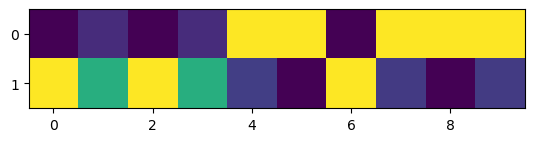

In [14]:
plt.imshow(linear_metrics['linear_ncmi'])
print(linear_metrics)

In [15]:
most_mixed_neuron = np.argmax(np.min(linear_metrics['linear_ncmi'], axis = 0))
most_mixed_neuron

4

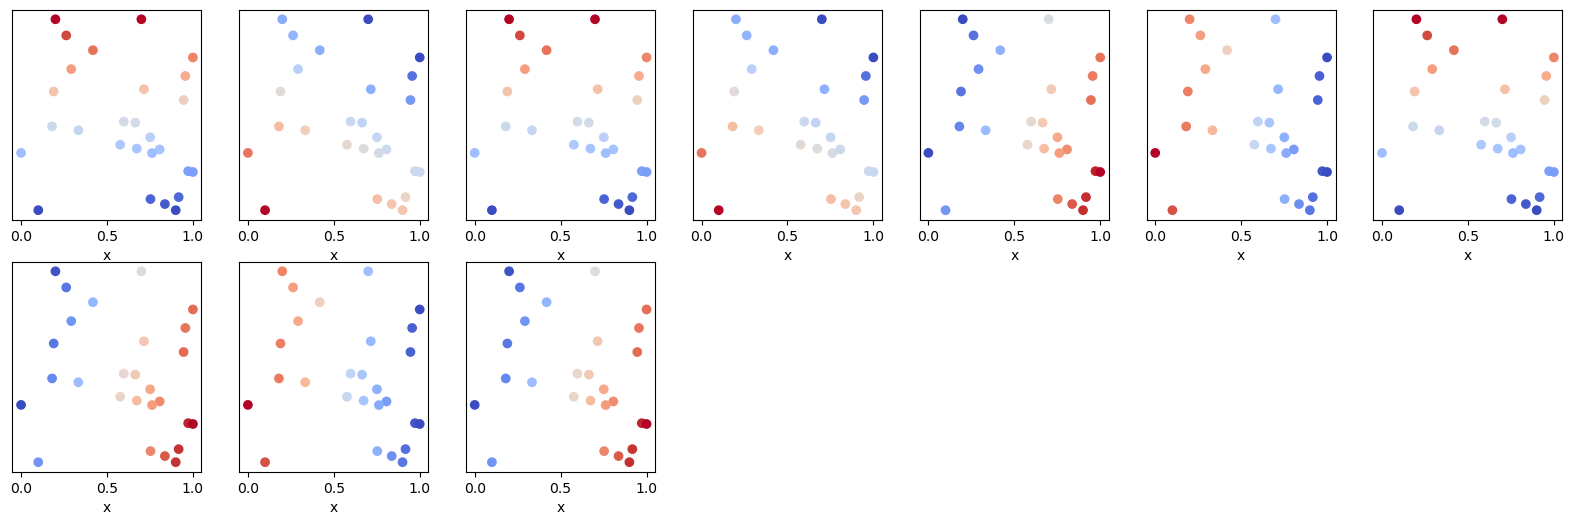

In [16]:
rows = 2
plt.figure(figsize = (20, 3*rows))

for neuron in range(H):
    plt.subplot(rows,int(H/rows)+2,neuron+1)
    plt.scatter(points[0,:], points[1,:], c = input_currents[neuron,:], cmap='coolwarm')
    #plt.ylim([min_current, max_current])
    plt.xlabel('x')

    #if neuron%5 != 0:
    plt.yticks([])
plt.show()

([], [])

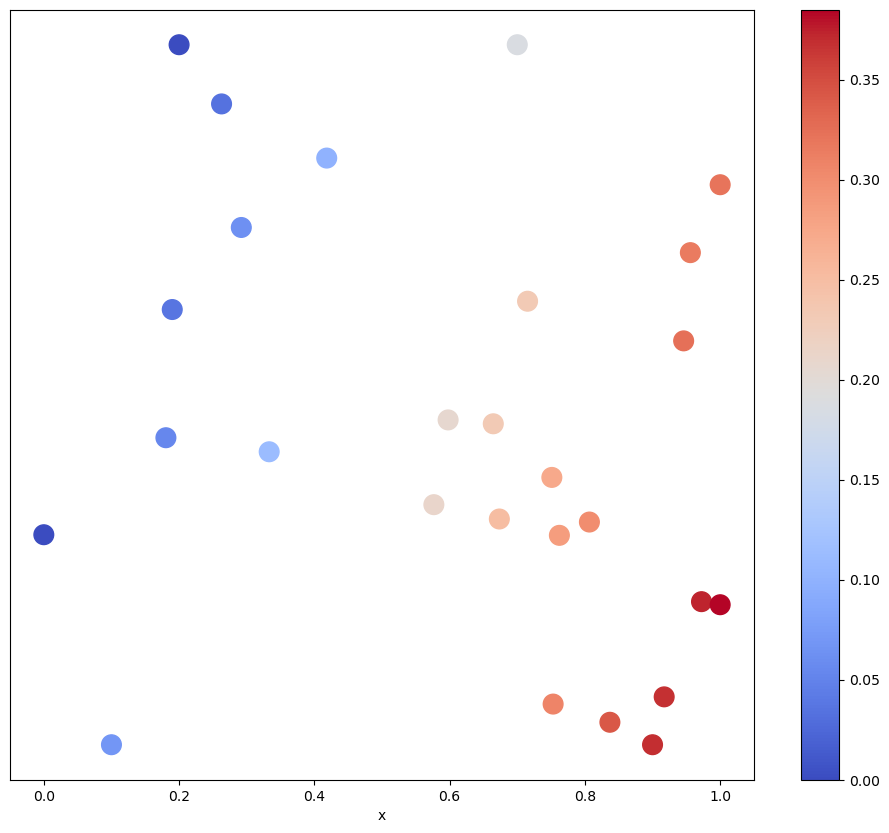

In [17]:
plt.figure(figsize = (12, 10))

plt.scatter(points[0,:], points[1,:], c = input_currents[most_mixed_neuron,:], cmap='coolwarm', s= 200)
#plt.ylim([min_current, max_current])
plt.xlabel('x')
plt.colorbar()
#if neuron%5 != 0:
plt.yticks([])

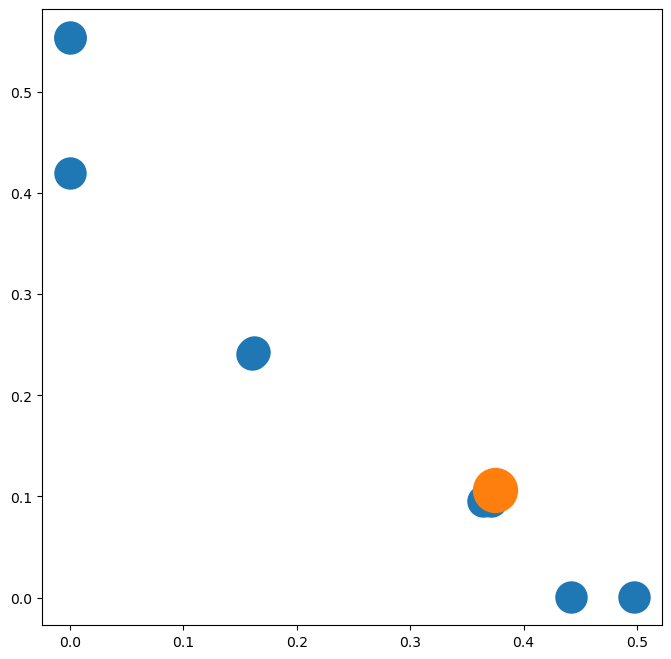

In [18]:
I = params_best['I'][:,:2]
plt.figure(figsize = (8,8))
neuron_choice = most_mixed_neuron
plt.scatter(np.abs(I[:,0]), np.abs(I[:,1]), s = 500)
plt.scatter(np.abs(I[neuron_choice,0]), np.abs(I[neuron_choice,1]), s= 1000)

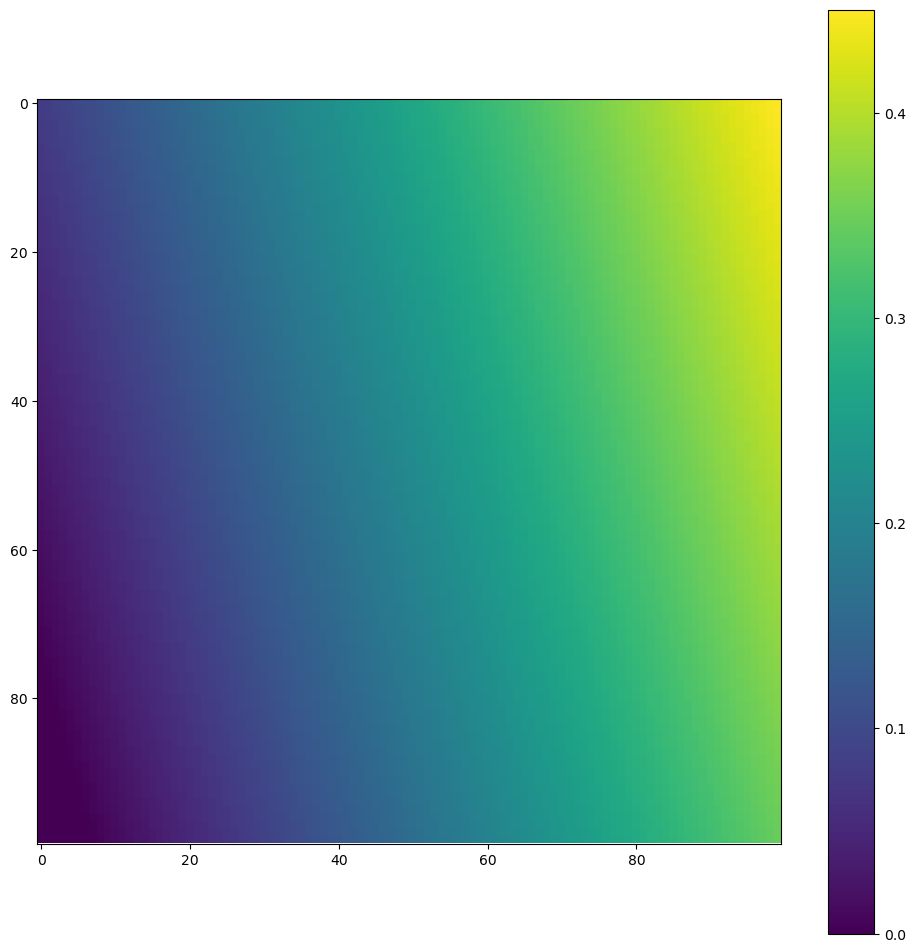

In [20]:
# Try a new input strategy to get gradients
inputs = np.meshgrid(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
inputs = np.stack([np.ndarray.flatten(inputs[0]), np.ndarray.flatten(inputs[1])])
inputs = inputs - np.mean(inputs, axis = 1)[:,None]
inputs_bias = np.vstack([inputs, np.ones([1,inputs.shape[1]])])
g = generate_rep(params_best['I'], inputs_bias)

plt.figure(figsize = (12,12))
plt.imshow(np.reshape(g[most_mixed_neuron,:], [len(np.arange(0, 1, 0.01)), len(np.arange(0, 1, 0.01))]))
plt.colorbar()

In [19]:
print(min_loss)
np.save(f"data/{today}/{now}_{random_seed}/params_best.npy", params_best)
np.save(f"data/{today}/{now}_{random_seed}/points.npy", points)


18.676777


FileNotFoundError: [Errno 2] No such file or directory: 'data/20240925/11:11:32_10/params_best.npy'

In [53]:
load_path = f"data/20240827/19:00:12_930960/"
#load_path = f"data/20240827/19:15:48_698689/"

points = np.load(f'{load_path}points.npy')
params_best = np.load(f'{load_path}params_best.npy', allow_pickle=True)[()]
points_demeaned = points - np.mean(points, axis = 1)[:,None]
points_bias = np.vstack([points_demeaned, np.ones([1,points_demeaned.shape[1]])])


In [61]:
params_best[()]

KeyError: ()

In [62]:
points_bias.shape

(3, 28)

In [40]:
g[most_mixed_neuron,:]

Array([0.3203557, 0.3193974, 0.318439 , ..., 0.       , 0.       ,
       0.       ], dtype=float32)